In [1]:
import pandas as pd
import numpy as np
import warnings 
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
warnings.filterwarnings('ignore')

In [3]:
data = pd.read_csv('2016_Building.csv',  engine = 'python',  on_bad_lines = 'skip')

In [4]:
data = pd.read_csv('2016_Building.csv',  engine = 'python',  on_bad_lines = 'skip')

In [5]:
data.head()

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,...,Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,0659000030,...,1.156514e+06,3946027.0,12764.52930,1276453.0,False,NaN,Compliant,NaN,249.98,2.83
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.0,0659000220,...,9.504252e+05,3242851.0,51450.81641,5145082.0,False,NaN,Compliant,NaN,295.86,2.86
2,3,2016,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,Seattle,WA,98101.0,0659000475,...,1.451544e+07,49526664.0,14938.00000,1493800.0,False,NaN,Compliant,NaN,2089.28,2.19
3,5,2016,NonResidential,Hotel,HOTEL MAX,620 STEWART ST,Seattle,WA,98101.0,0659000640,...,8.115253e+05,2768924.0,18112.13086,1811213.0,False,NaN,Compliant,NaN,286.43,4.67
4,8,2016,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,Seattle,WA,98121.0,0659000970,...,1.573449e+06,5368607.0,88039.98438,8803998.0,False,NaN,Compliant,NaN,505.01,2.88


In [6]:
data.shape

(3376, 46)

# 1. Nettoyage des données

## 1.1  éliminer les propriétes avec les conditions :
- Building résidentiel (Multifamily)
- Building with default data (The property used default data for at least one property characteristic.)
- Outliers buildings  (Whether a property is a high or low outlier (Y/N))
- Compliances (Whether a property has met energy benchmarking requirements for the current reporting year.)

In [7]:
data.BuildingType.str.contains('Multifamily').sum()/len(data)
data['DefaultData'].apply(lambda x: x).sum()/len(data)
data['Outlier'].notnull().sum()/len(data)
data['ComplianceStatus'].apply(lambda x: (x != 'Compliant')).sum()/len(data)

0.04887440758293839

In [8]:
data.BuildingType.str.contains('Multifamily').sum() + data['DefaultData'].apply(lambda x: x).sum() + data['Outlier'].notnull().sum() + data['ComplianceStatus'].apply(lambda x: (x != 'Compliant')).sum()

2018

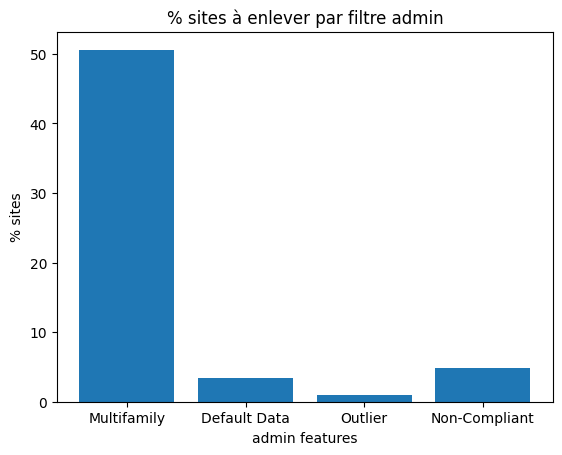

In [9]:
# Calculate the percentages
multifamily_pct = 100*data.BuildingType.str.contains('Multifamily').sum() / len(data)
default_data_pct = 100*data['DefaultData'].apply(lambda x: x).sum() / len(data)
outlier_pct = 100*data['Outlier'].notnull().sum() / len(data)
compliance_pct = 100*data['ComplianceStatus'].apply(lambda x: (x != 'Compliant')).sum() / len(data)

# Create the bar plot
values = [multifamily_pct, default_data_pct, outlier_pct, compliance_pct]
labels = ['Multifamily', 'Default Data', 'Outlier', 'Non-Compliant']
plt.bar(labels, values)

# Add labels and title
plt.xlabel('admin features')
plt.ylabel('% sites')
plt.title('% sites à enlever par filtre admin')

plt.show()

In [10]:
data_1 = data.drop(data[data['BuildingType'].str.contains('Multifamily')].index)
data_1 = data_1.drop(data_1[data_1['DefaultData']].index)
data_1 = data_1.drop(data_1[~data_1['ComplianceStatus'].str.contains('Compliant')].index)
data_1 = data_1.drop(data_1[data_1['Outlier'].notnull()].index)

In [11]:
data_1.shape

(1551, 46)

# 1.2. Doublons

In [12]:
data_1.duplicated().sum()

0

In [13]:
data_1.to_csv('data_1.csv')

# 2  Feature engineering 

## 2.1.  Définition des variable cibles et  éliminer les features  qui ne sont pas utiles :
On choisit SiteEUI(kBtu/sf) et GHGEmissionsIntensity comme variables cibles 

In [14]:
data_1.columns

Index(['OSEBuildingID', 'DataYear', 'BuildingType', 'PrimaryPropertyType',
       'PropertyName', 'Address', 'City', 'State', 'ZipCode',
       'TaxParcelIdentificationNumber', 'CouncilDistrictCode', 'Neighborhood',
       'Latitude', 'Longitude', 'YearBuilt', 'NumberofBuildings',
       'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking',
       'PropertyGFABuilding(s)', 'ListOfAllPropertyUseTypes',
       'LargestPropertyUseType', 'LargestPropertyUseTypeGFA',
       'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA',
       'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA',
       'YearsENERGYSTARCertified', 'ENERGYSTARScore', 'SiteEUI(kBtu/sf)',
       'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)',
       'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)',
       'Electricity(kWh)', 'Electricity(kBtu)', 'NaturalGas(therms)',
       'NaturalGas(kBtu)', 'DefaultData', 'Comments', 'ComplianceStatus',
       'Outlier

In [15]:
Nouse_features = ['DataYear', 'PropertyName', 'BuildingType', 'City', 'State', 'ZipCode', 'Outlier', 'ComplianceStatus','DefaultData', 'YearsENERGYSTARCertified', 'TaxParcelIdentificationNumber', 'Address', 'Comments',\
                 'NumberofBuildings', 'OSEBuildingID']

In [16]:
data_2 = data_1.drop(columns = Nouse_features)

In [17]:
# Supprimer les colonnes non numériques ou non pertinentes
data_2 = data_2.drop(['Latitude', 'Longitude', 'PropertyGFABuilding(s)', 'Electricity(kWh)', 'NaturalGas(therms)', 'TotalGHGEmissions'], axis=1)


Supprimer les variables numériques énergie qui ne sont pas dispo pour les nouveaus batiments

In [18]:
data_2 = data_2.drop(['SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)', 'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)'], axis=1)


In [19]:
data_2.shape

(1551, 20)

## 2.2  Traiement des valeurs des variables numériques

### 2.2.1 valeurs manquantes

In [20]:
data_3 = data_2.copy()

In [21]:
print(data_3.isnull().sum())

PrimaryPropertyType                   0
CouncilDistrictCode                   0
Neighborhood                          0
YearBuilt                             0
NumberofFloors                        0
PropertyGFATotal                      0
PropertyGFAParking                    0
ListOfAllPropertyUseTypes             2
LargestPropertyUseType                6
LargestPropertyUseTypeGFA             6
SecondLargestPropertyUseType        708
SecondLargestPropertyUseTypeGFA     708
ThirdLargestPropertyUseType        1203
ThirdLargestPropertyUseTypeGFA     1203
ENERGYSTARScore                     554
SiteEUI(kBtu/sf)                      3
SteamUse(kBtu)                        2
Electricity(kBtu)                     2
NaturalGas(kBtu)                      2
GHGEmissionsIntensity                 2
dtype: int64


In [22]:
# Calculer la moyenne de ENERGYSTARScore par groupe de PrimaryPropertyType
moyenne_par_proprietyType = data_3.groupby('PrimaryPropertyType')['ENERGYSTARScore'].mean()

# Calculer la moyenne de toutes les valeurs non manquantes de ENERGYSTARScore
overall_mean = data_3['ENERGYSTARScore'].mean()

# Remplacer les valeurs manquantes de ENERGYSTARScore par la moyenne de groupe de PrimaryPropertyType
data_3['ENERGYSTARScore'] = data_3.apply(lambda row: moyenne_par_proprietyType[row['PrimaryPropertyType']] \
    if np.isnan(row['ENERGYSTARScore']) else row['ENERGYSTARScore'],  axis=1)

In [23]:
print(data_3.isnull().sum())

PrimaryPropertyType                   0
CouncilDistrictCode                   0
Neighborhood                          0
YearBuilt                             0
NumberofFloors                        0
PropertyGFATotal                      0
PropertyGFAParking                    0
ListOfAllPropertyUseTypes             2
LargestPropertyUseType                6
LargestPropertyUseTypeGFA             6
SecondLargestPropertyUseType        708
SecondLargestPropertyUseTypeGFA     708
ThirdLargestPropertyUseType        1203
ThirdLargestPropertyUseTypeGFA     1203
ENERGYSTARScore                      74
SiteEUI(kBtu/sf)                      3
SteamUse(kBtu)                        2
Electricity(kBtu)                     2
NaturalGas(kBtu)                      2
GHGEmissionsIntensity                 2
dtype: int64


In [24]:
# Remplacer le reste des valeurs manquantes de ENERGYSTARScore par la moyenne global de ENERGYSTARScore
data_3['ENERGYSTARScore'] = data_3.apply(lambda row: overall_mean\
    if np.isnan(row['ENERGYSTARScore']) else row['ENERGYSTARScore'],  axis=1)

In [25]:
# drop les batiments avec les valeurs manquantes sur SiteEUI(kBtu/sf)    GHGEmissionsIntensity      

In [26]:
data_3 = data_3.dropna(subset=['SiteEUI(kBtu/sf)'])

In [27]:
print(data_3.isnull().sum())

PrimaryPropertyType                   0
CouncilDistrictCode                   0
Neighborhood                          0
YearBuilt                             0
NumberofFloors                        0
PropertyGFATotal                      0
PropertyGFAParking                    0
ListOfAllPropertyUseTypes             0
LargestPropertyUseType                4
LargestPropertyUseTypeGFA             4
SecondLargestPropertyUseType        706
SecondLargestPropertyUseTypeGFA     706
ThirdLargestPropertyUseType        1200
ThirdLargestPropertyUseTypeGFA     1200
ENERGYSTARScore                       0
SiteEUI(kBtu/sf)                      0
SteamUse(kBtu)                        0
Electricity(kBtu)                     0
NaturalGas(kBtu)                      0
GHGEmissionsIntensity                 0
dtype: int64


In [28]:
data_3.shape

(1548, 20)

### 2.2.2  Valeur incorrecte

In [29]:
# if numberofflower is 0, put it into 1. 

data_3['NumberofFloors'] = data_3['NumberofFloors'].replace(0,1)

### 2.2.3  invalides :  
remove row with negative values

In [30]:
keep_columns = ['PrimaryPropertyType', 'Neighborhood', 'ListOfAllPropertyUseTypes', 'LargestPropertyUseType', 'SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType']

# Create a mask to identify rows with negative values
mask = (data_3.drop(keep_columns, axis=1) < 0).any(axis=1)

# Drop the rows with negative values
data_3 = data_3[~mask]

In [31]:
data_3.shape

(1547, 20)

In [32]:
# d'autres zero value to check 

In [33]:
count_zeros = data_3.eq(0).sum()
print(count_zeros)

PrimaryPropertyType                   0
CouncilDistrictCode                   0
Neighborhood                          0
YearBuilt                             0
NumberofFloors                        0
PropertyGFATotal                      0
PropertyGFAParking                 1217
ListOfAllPropertyUseTypes             0
LargestPropertyUseType                0
LargestPropertyUseTypeGFA             0
SecondLargestPropertyUseType          0
SecondLargestPropertyUseTypeGFA      76
ThirdLargestPropertyUseType           0
ThirdLargestPropertyUseTypeGFA       24
ENERGYSTARScore                       0
SiteEUI(kBtu/sf)                      0
SteamUse(kBtu)                     1434
Electricity(kBtu)                     2
NaturalGas(kBtu)                    443
GHGEmissionsIntensity                 1
dtype: int64


In [34]:
data_3 = data_3.drop(data_3[data_3['GHGEmissionsIntensity']==0].index)

In [35]:
count_zeros = data_3.eq(0).sum()
print(count_zeros)

PrimaryPropertyType                   0
CouncilDistrictCode                   0
Neighborhood                          0
YearBuilt                             0
NumberofFloors                        0
PropertyGFATotal                      0
PropertyGFAParking                 1216
ListOfAllPropertyUseTypes             0
LargestPropertyUseType                0
LargestPropertyUseTypeGFA             0
SecondLargestPropertyUseType          0
SecondLargestPropertyUseTypeGFA      76
ThirdLargestPropertyUseType           0
ThirdLargestPropertyUseTypeGFA       24
ENERGYSTARScore                       0
SiteEUI(kBtu/sf)                      0
SteamUse(kBtu)                     1433
Electricity(kBtu)                     1
NaturalGas(kBtu)                    442
GHGEmissionsIntensity                 0
dtype: int64


In [36]:
data_3.to_csv('data_3.csv')

### 2.2.4   traitement outliers

In [37]:
Q1 = data_3.quantile(0.25)
Q3 = data_3.quantile(0.75)
IQR = Q3 - Q1
outliers = (data_3 < (Q1 - 1.5 * IQR)) | (data_3 > (Q3 + 1.5 * IQR))
outliers_num = (outliers == True).sum().sort_values(ascending=False)
outliers_per = (((outliers == True).sum()/len(data_3))*100).sort_values(ascending=False)
(outliers == True).sum().sum()

1834

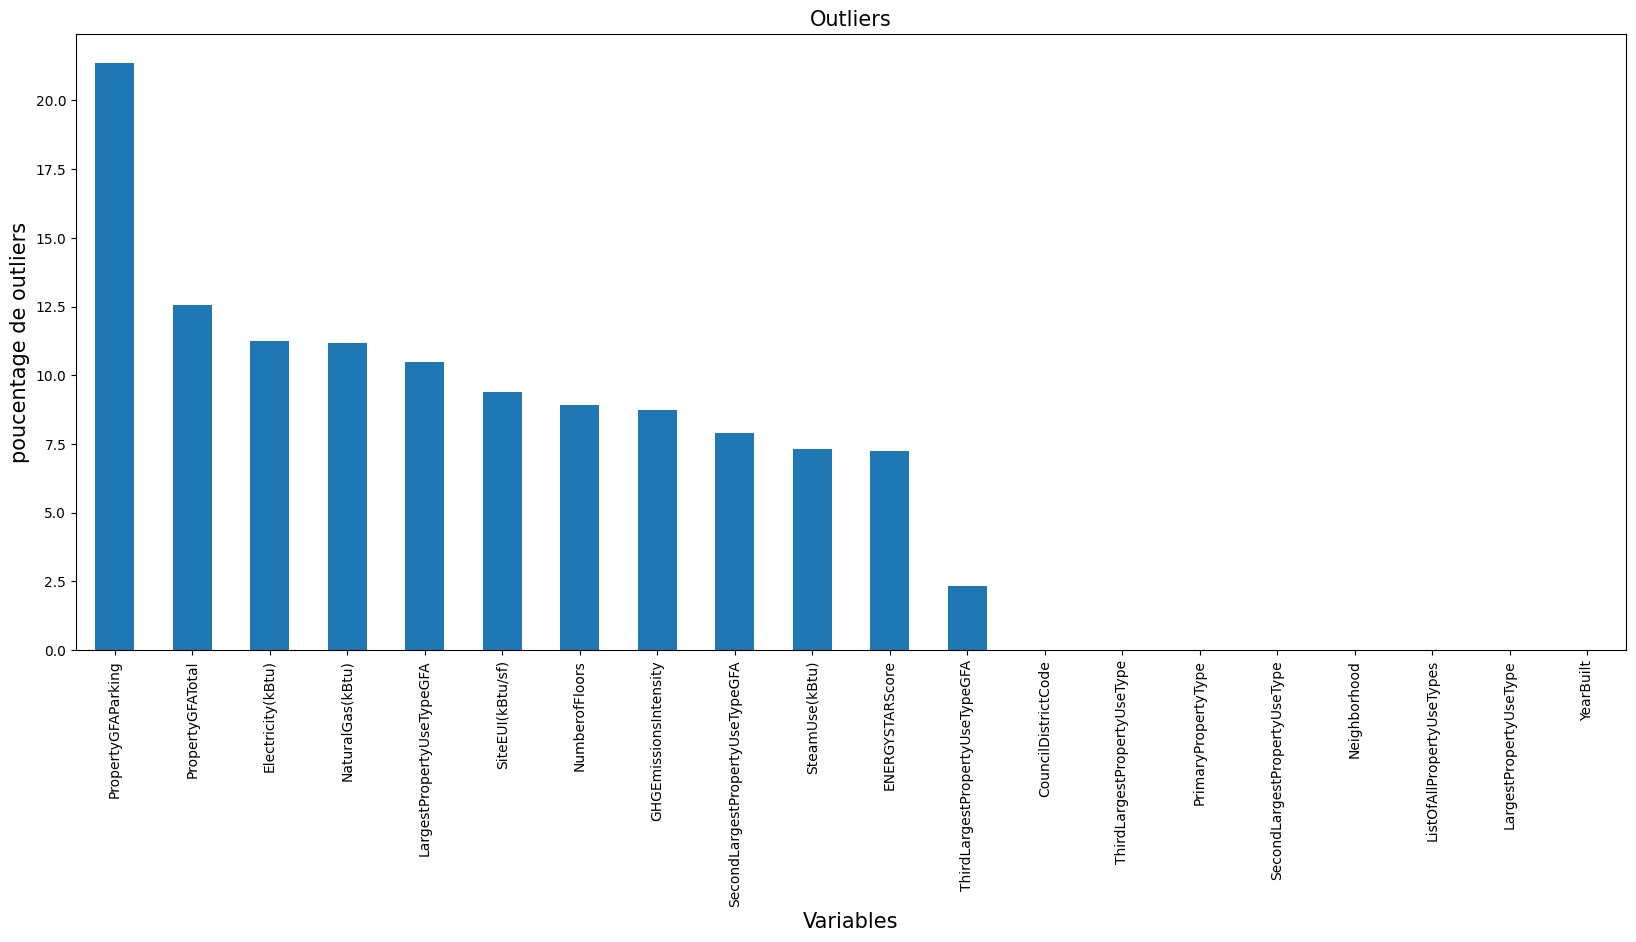

In [38]:
outliers_per.plot(kind='bar', figsize=(20, 8))
plt.xlabel('Variables', fontsize=15)
plt.ylabel('poucentage de outliers', fontsize=15)
plt.title('Outliers', fontsize=15)
plt.show()

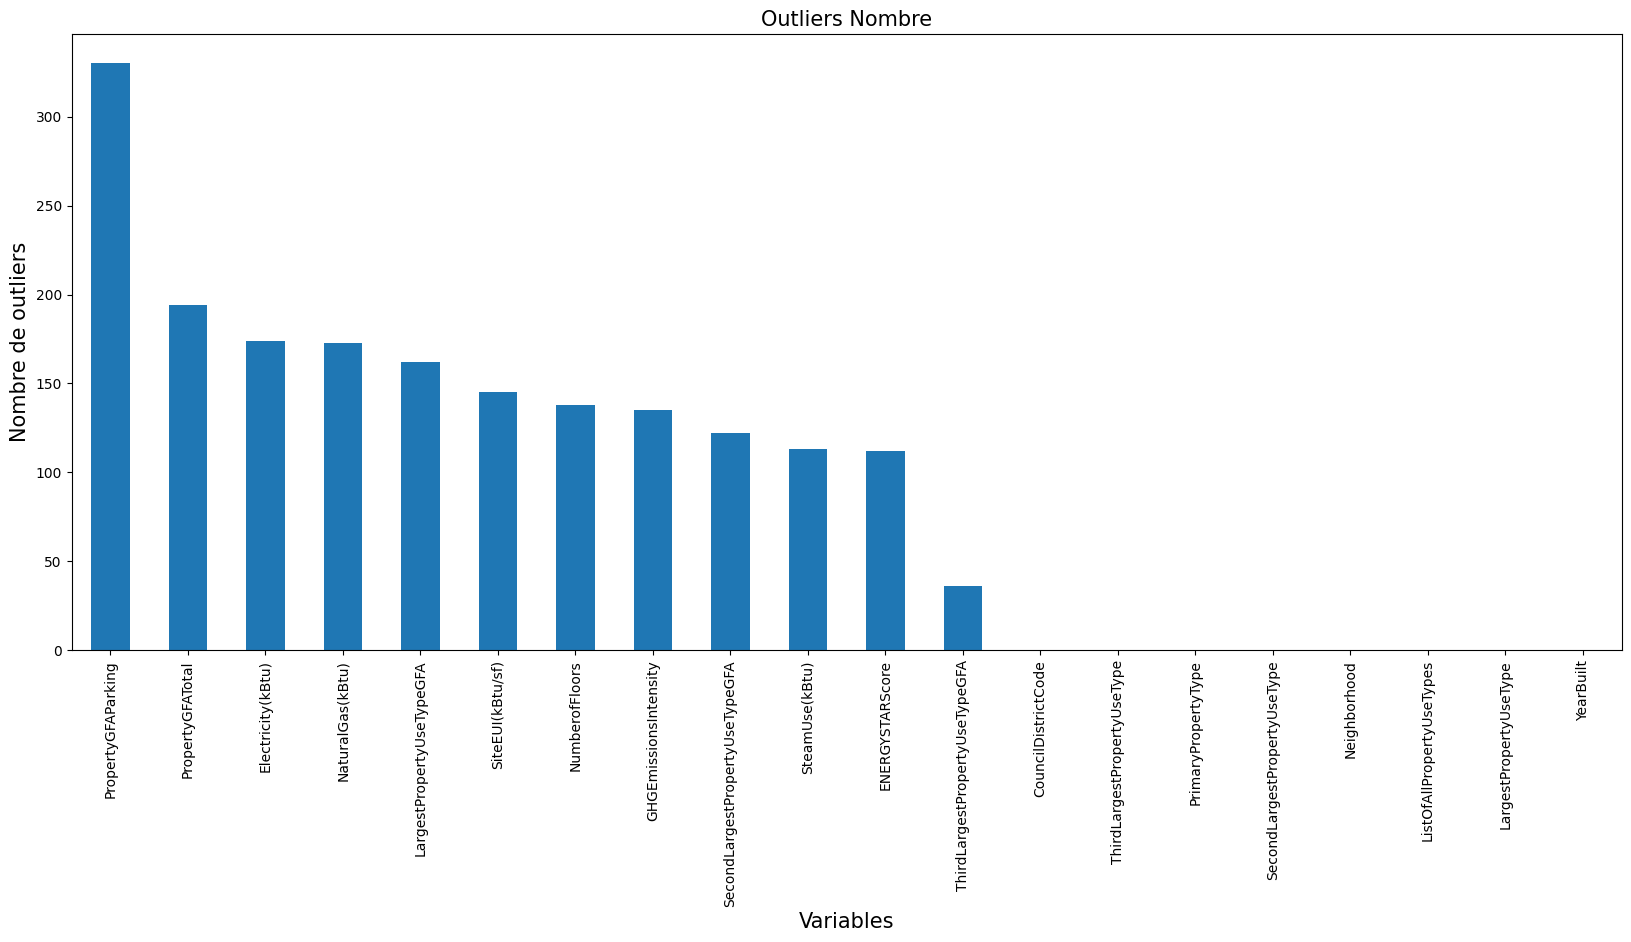

In [39]:
outliers_num.plot(kind='bar', figsize=(20, 8))
plt.xlabel('Variables', fontsize=15)
plt.ylabel('Nombre de outliers', fontsize=15)
plt.title('Outliers Nombre', fontsize=15)
plt.show()

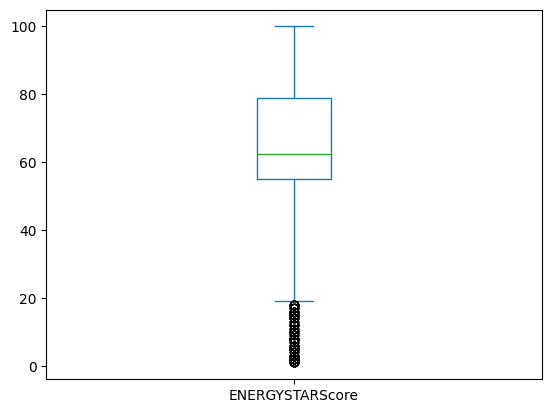

In [40]:
data_3['ENERGYSTARScore'].plot.box()
plt.show()

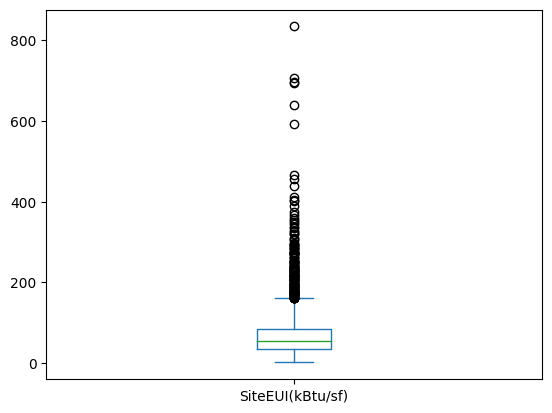

In [41]:
data_3['SiteEUI(kBtu/sf)'].plot.box()
plt.show()

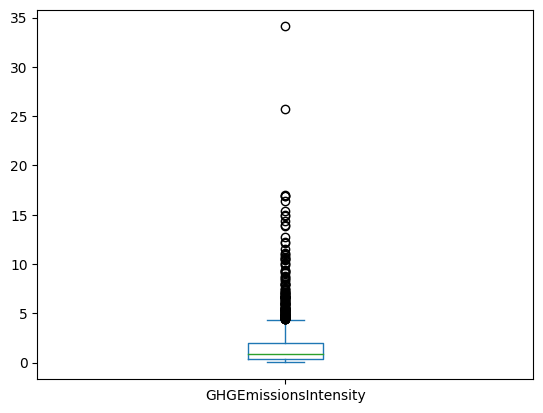

In [42]:
data_3['GHGEmissionsIntensity'].plot.box()
plt.show()

## 2.3 Corrélation entre les variables numériques 

In [43]:
variables_num = ['NumberofFloors', 'ENERGYSTARScore', 'SiteEUI(kBtu/sf)','GHGEmissionsIntensity']

In [44]:
data_num = data_3[variables_num]
data_num.head()

,NumberofFloors,ENERGYSTARScore,SiteEUI(kBtu/sf),GHGEmissionsIntensity
0,12,60.0,81.699997,2.83
1,11,61.0,94.800003,2.86
2,41,43.0,96.000000,2.19
3,10,56.0,110.800003,4.67
4,18,75.0,114.800003,2.88


<Axes: >

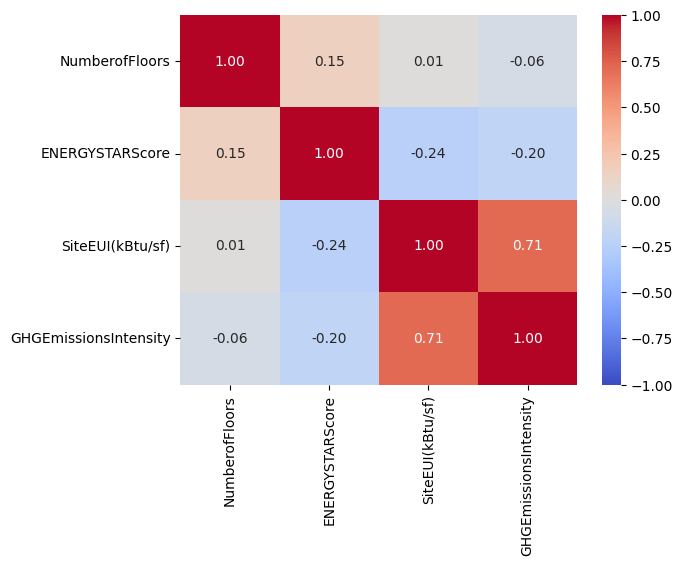

In [45]:
sns.heatmap(data_num.corr(), vmin=-1, vmax=1, annot=True, cmap="coolwarm", fmt="0.2f")

In [46]:
corre = data_num.corr()

<Axes: >

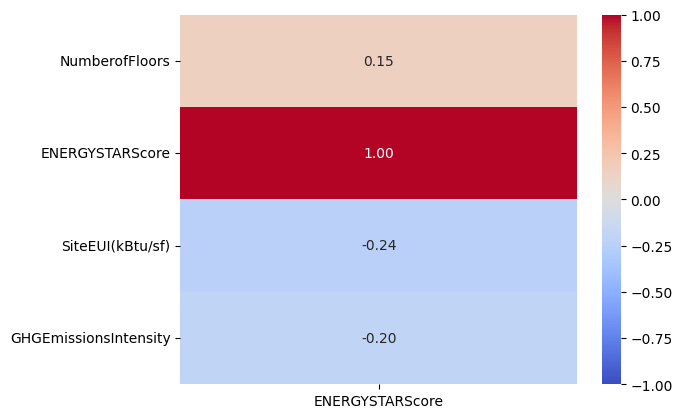

In [47]:
sns.heatmap(corre.loc[:,['ENERGYSTARScore']], vmin=-1, vmax=1, annot=True, cmap="coolwarm", fmt="0.2f")

Les variables dans data_num ne sont pas fortement corrélées

## 2.4 Les variables catégorielles

In [48]:
data_4 = data_3.copy()

In [49]:
# group build year in 4 interval and dummy encode it 
data_4['Interval'] = pd.cut(data_4['YearBuilt'], bins=[data['YearBuilt'].min(), 1945, 1970, 1990, data['YearBuilt'].max()],\
                          labels=[f"{data_4['YearBuilt'].min()}-1945", "1946-1970", "1971-1990", f"1991-{data['YearBuilt'].max()}"])


data_4['Interval'].head()

0    1900-1945
1    1991-2015
2    1946-1970
3    1900-1945
4    1971-1990
Name: Interval, dtype: category
Categories (4, object): ['1900-1945' < '1946-1970' < '1971-1990' < '1991-2015']

In [50]:
data_4.columns

Index(['PrimaryPropertyType', 'CouncilDistrictCode', 'Neighborhood',
       'YearBuilt', 'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking',
       'ListOfAllPropertyUseTypes', 'LargestPropertyUseType',
       'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseType',
       'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseType',
       'ThirdLargestPropertyUseTypeGFA', 'ENERGYSTARScore', 'SiteEUI(kBtu/sf)',
       'SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)',
       'GHGEmissionsIntensity', 'Interval'],
      dtype='object')

Etude relation des variables catégorielles avec les variables ciblespour choisir les variables pertinentes

Etude 'PrimaryPropertyType'

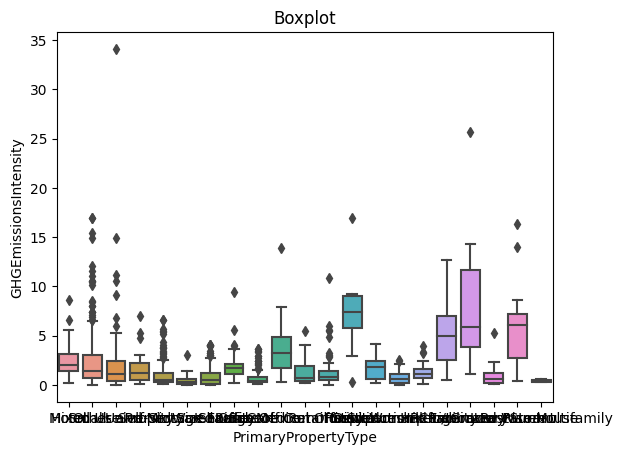

In [51]:
import seaborn as sns
# Tracer un boxplot
sns.boxplot(x='PrimaryPropertyType', y='GHGEmissionsIntensity', data=data_4)

# Ajouter un titre
plt.title('Boxplot')
plt.show()

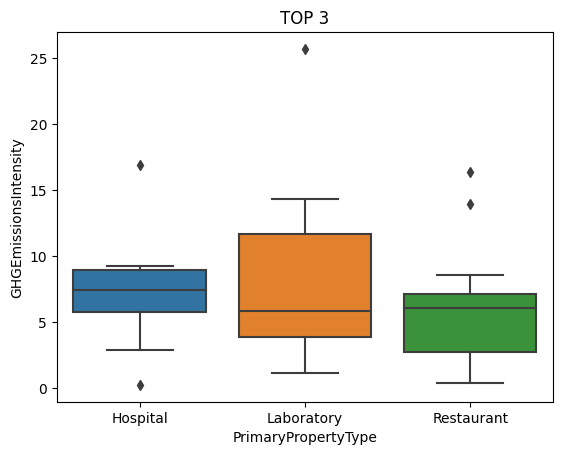

In [52]:
# Tracer un boxplot des top 

# Obtenir les catégories avec les 5 plus grandes valeurs moyennes
top_categories = data.groupby('PrimaryPropertyType')['GHGEmissionsIntensity'].mean().sort_values(ascending=False)[:3].index.tolist()

# Obtenir les catégories avec les 5 plus petites valeurs moyennes
bottom_categories = data.groupby('PrimaryPropertyType')['GHGEmissionsIntensity'].mean().sort_values()[:0].index.tolist()

# Créer un nouveau dataframe avec seulement les catégories sélectionnées
selected_categories = top_categories + bottom_categories
data_selected = data_4[data_4['PrimaryPropertyType'].isin(selected_categories)]

sns.boxplot(x='PrimaryPropertyType', y='GHGEmissionsIntensity', data=data_selected)

# Ajouter un titre
plt.title('TOP 3')
plt.show()

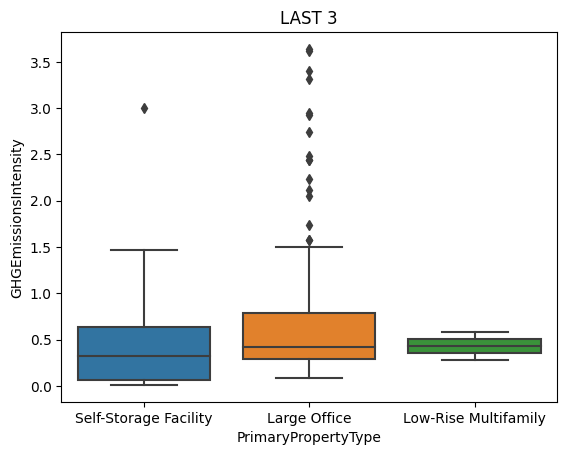

In [53]:

# Obtenir les catégories avec les 5 plus grandes valeurs moyennes
top_categories = data_4.groupby('PrimaryPropertyType')['GHGEmissionsIntensity'].mean().sort_values(ascending=False)[:0].index.tolist()

# Obtenir les catégories avec les 5 plus petites valeurs moyennes
bottom_categories = data_4.groupby('PrimaryPropertyType')['GHGEmissionsIntensity'].mean().sort_values()[:3].index.tolist()

# Créer un nouveau dataframe avec seulement les catégories sélectionnées
selected_categories = top_categories + bottom_categories
data_selected = data_4[data_4['PrimaryPropertyType'].isin(selected_categories)]

sns.boxplot(x='PrimaryPropertyType', y='GHGEmissionsIntensity', data=data_selected)

# Ajouter un titre
plt.title('LAST 3')
plt.show()

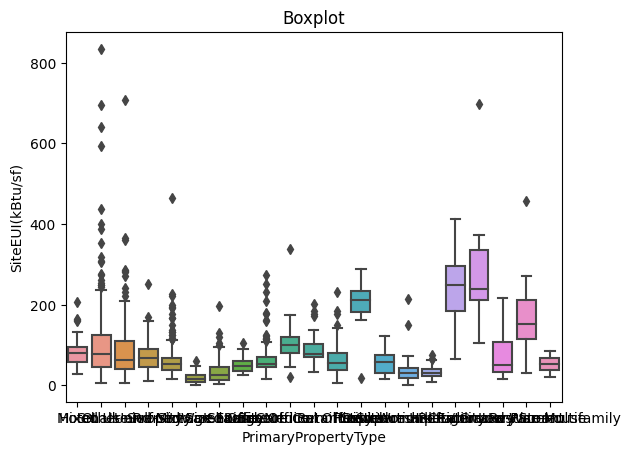

In [54]:
# Tracer un boxplot
sns.boxplot(x='PrimaryPropertyType', y='SiteEUI(kBtu/sf)', data=data_4)

# Ajouter un titre
plt.title('Boxplot')
plt.show()

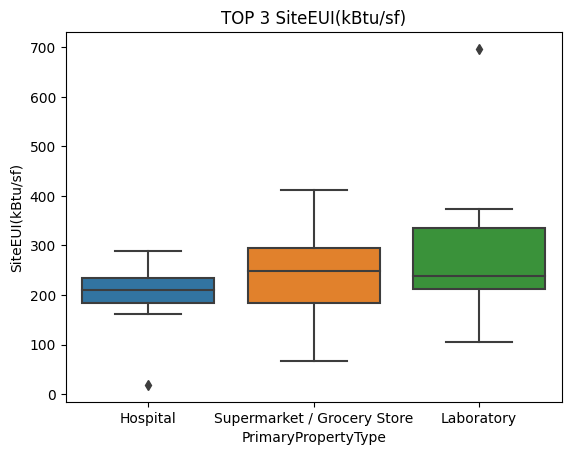

In [55]:
# Obtenir les catégories avec les 5 plus grandes valeurs moyennes
top_categories = data_4.groupby('PrimaryPropertyType')['SiteEUI(kBtu/sf)'].mean().sort_values(ascending=False)[:3].index.tolist()

# Obtenir les catégories avec les 5 plus petites valeurs moyennes
bottom_categories = data_4.groupby('PrimaryPropertyType')['SiteEUI(kBtu/sf)'].mean().sort_values()[:0].index.tolist()

# Créer un nouveau dataframe avec seulement les catégories sélectionnées
selected_categories = top_categories + bottom_categories
data_selected = data_4[data_4['PrimaryPropertyType'].isin(selected_categories)]

sns.boxplot(x='PrimaryPropertyType', y='SiteEUI(kBtu/sf)', data=data_selected)

# Ajouter un titre
plt.title('TOP 3 SiteEUI(kBtu/sf)')
plt.show()

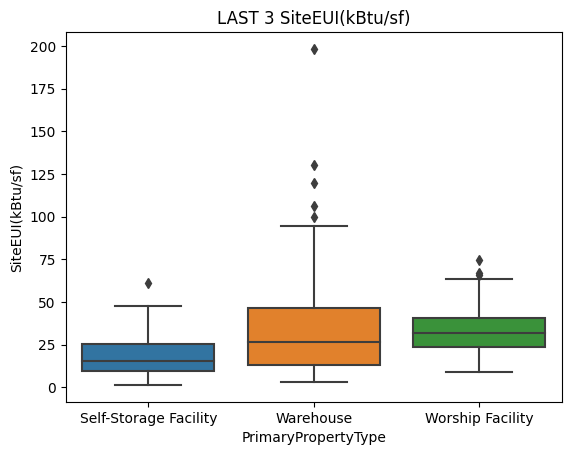

In [56]:
# Obtenir les catégories avec les 5 plus grandes valeurs moyennes
top_categories = data_4.groupby('PrimaryPropertyType')['SiteEUI(kBtu/sf)'].mean().sort_values(ascending=False)[:0].index.tolist()

# Obtenir les catégories avec les 5 plus petites valeurs moyennes
bottom_categories = data_4.groupby('PrimaryPropertyType')['SiteEUI(kBtu/sf)'].mean().sort_values()[:3].index.tolist()

# Créer un nouveau dataframe avec seulement les catégories sélectionnées
selected_categories = top_categories + bottom_categories
data_selected = data_4[data_4['PrimaryPropertyType'].isin(selected_categories)]

sns.boxplot(x='PrimaryPropertyType', y='SiteEUI(kBtu/sf)', data=data_selected)

# Ajouter un titre
plt.title('LAST 3 SiteEUI(kBtu/sf)')
plt.show()

Etude 'CouncilDistrictCode'  ==> pas de relation forte 

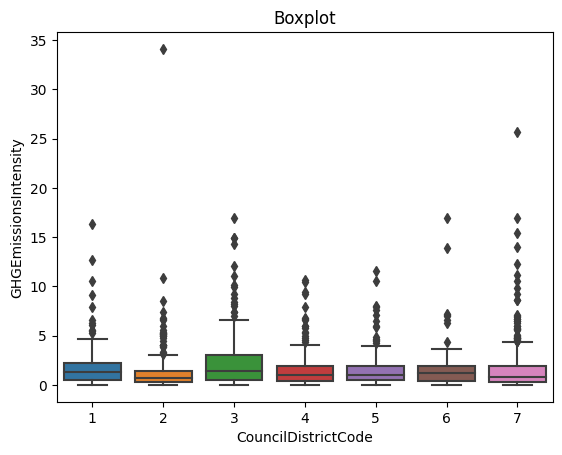

In [57]:
# Tracer un boxplot
sns.boxplot(x='CouncilDistrictCode', y='GHGEmissionsIntensity', data=data_4)

# Ajouter un titre
plt.title('Boxplot')
plt.show()

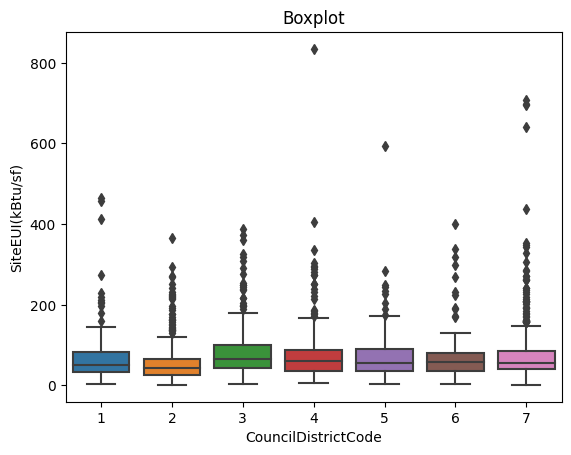

In [58]:
# Tracer un boxplot
sns.boxplot(x='CouncilDistrictCode', y='SiteEUI(kBtu/sf)', data=data_4)

# Ajouter un titre
plt.title('Boxplot')
plt.show()

Etude 'Neighborhood'  ==>  relation assez forte 

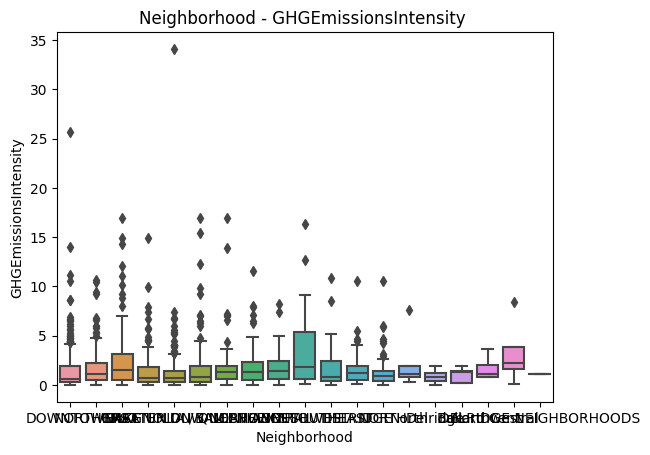

In [59]:
sns.boxplot(x='Neighborhood', y='GHGEmissionsIntensity', data=data_4)

# Ajouter un titre
plt.title('Neighborhood - GHGEmissionsIntensity ')
plt.show()

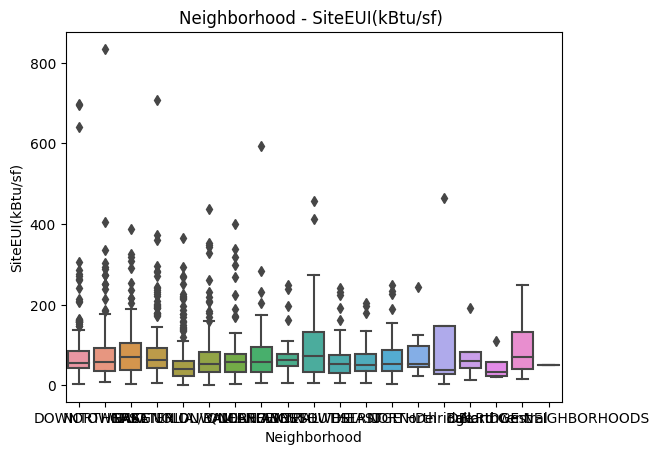

In [60]:
# Tracer un boxplot
sns.boxplot(x='Neighborhood', y='SiteEUI(kBtu/sf)', data=data_4)

# Ajouter un titre
plt.title('Neighborhood - SiteEUI(kBtu/sf) ')
plt.show()

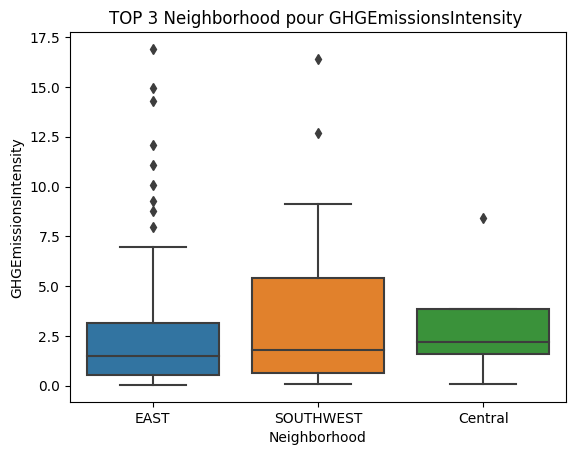

In [61]:
# Obtenir les catégories avec les 5 plus grandes valeurs moyennes
top_categories = data_4.groupby('Neighborhood')['GHGEmissionsIntensity'].mean().sort_values(ascending=False)[:3].index.tolist()

# Obtenir les catégories avec les 5 plus petites valeurs moyennes
bottom_categories = data_4.groupby('Neighborhood')['GHGEmissionsIntensity'].mean().sort_values()[:0].index.tolist()

# Créer un nouveau dataframe avec seulement les catégories sélectionnées
selected_categories = top_categories + bottom_categories
data_selected = data_4[data_4['Neighborhood'].isin(selected_categories)]

sns.boxplot(x='Neighborhood', y='GHGEmissionsIntensity', data=data_selected)

# Ajouter un titre
plt.title('TOP 3 Neighborhood pour GHGEmissionsIntensity ')
plt.show()

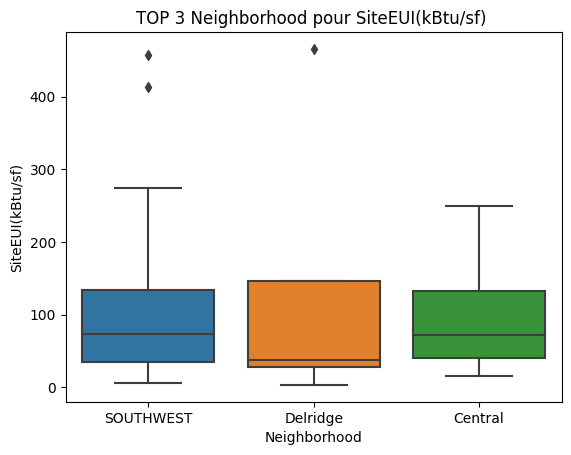

In [62]:
# Obtenir les catégories avec les 5 plus grandes valeurs moyennes
top_categories = data_4.groupby('Neighborhood')['SiteEUI(kBtu/sf)'].mean().sort_values(ascending=False)[:3].index.tolist()

# Obtenir les catégories avec les 5 plus petites valeurs moyennes
bottom_categories = data_4.groupby('Neighborhood')['SiteEUI(kBtu/sf)'].mean().sort_values()[:0].index.tolist()

# Créer un nouveau dataframe avec seulement les catégories sélectionnées
selected_categories = top_categories + bottom_categories
data_selected = data_4[data_4['Neighborhood'].isin(selected_categories)]

sns.boxplot(x='Neighborhood', y='SiteEUI(kBtu/sf)', data=data_selected)

# Ajouter un titre
plt.title('TOP 3 Neighborhood pour SiteEUI(kBtu/sf) ')
plt.show()

Etude 'BuiltYear'  ==>  relation faible

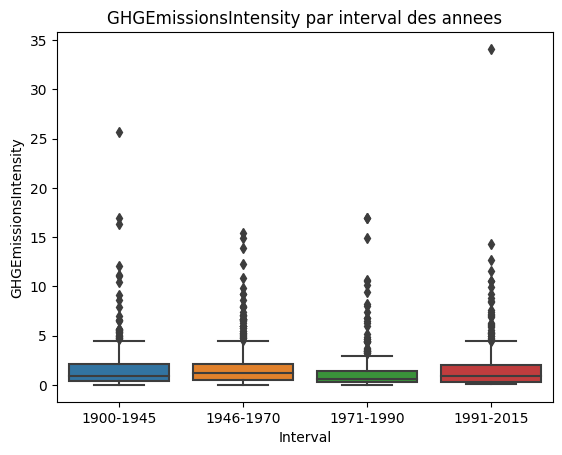

In [63]:
# Tracer un boxplot
sns.boxplot(x='Interval', y='GHGEmissionsIntensity', data=data_4)

# Ajouter un titre
plt.title('GHGEmissionsIntensity par interval des annees')
plt.show()

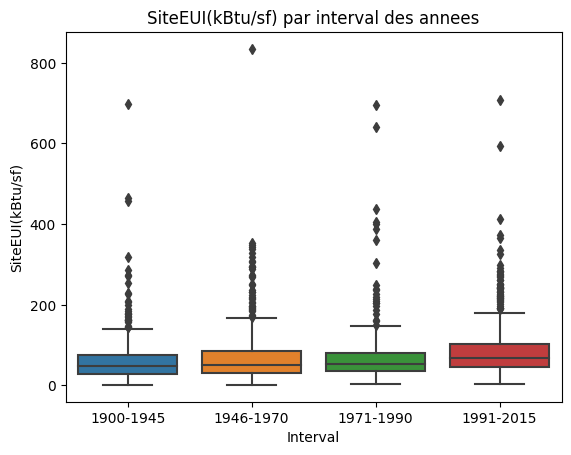

In [64]:
# Tracer un boxplot
sns.boxplot(x='Interval', y='SiteEUI(kBtu/sf)', data=data_4)

# Ajouter un titre
plt.title('SiteEUI(kBtu/sf) par interval des annees')
plt.show()

On utilise Neighborhood et PrimaryPropertyType

## 2.5 Transformation variables numériques

pour les variables type énergies, on les transforme en variable catégorielle binaire, 

In [65]:
data_4['Electricity'] = data_4['Electricity(kBtu)'].apply(lambda x: 1 if x > 0 else 0)
data_4['Gas'] = data_4['NaturalGas(kBtu)'].apply(lambda x: 1 if x > 0 else 0)
data_4['Steam'] = data_4['SteamUse(kBtu)'].apply(lambda x: 1 if x > 0 else 0)

data_4 = data_4.drop(['Electricity(kBtu)', 'NaturalGas(kBtu)', 'SteamUse(kBtu)'], axis = 1)

In [66]:
energy_name = ['Electricity', 'Gas', 'Steam']
Energy_type = data_4[energy_name]

In [67]:
# Enlever l'espace après le virgule
data_4['ListOfAllPropertyUseTypes'] = data_4['ListOfAllPropertyUseTypes'].apply(lambda x: x.replace(", ", ","))

In [80]:
# Créer une copie du DataFrame
df_copie = data_4.copy()

# Séparer les types dans la copie de la colonne en une liste
df_copie['ListOfAllPropertyUseTypes'] = df_copie['ListOfAllPropertyUseTypes'].str.split(',')

# Convertir chaque liste en une ligne individuelle dans la copie
df_copie = df_copie.explode('ListOfAllPropertyUseTypes')

# Extraire les types individuels uniques de la copie
PropertyUseTypes = df_copie['ListOfAllPropertyUseTypes'].unique().tolist()

print(PropertyUseTypes)

# Création des colonnes pour chaque valeur de la liste
for use_type in PropertyUseTypes:
    data_4[use_type] = 0

['Hotel', 'Parking', 'Restaurant', 'Swimming Pool', 'Police Station', 'Other - Entertainment/Public Assembly', 'Data Center', 'Library', 'Fitness Center/Health Club/Gym', 'Office', 'Other', 'Other - Lodging/Residential', 'Social/Meeting Hall', 'Courthouse', 'College/University', 'Automobile Dealership', 'Retail Store', 'K-12 School', 'Multifamily Housing', 'Self-Storage Facility', 'Energy/Power Station', 'Laboratory', 'Manufacturing/Industrial Plant', 'Non-Refrigerated Warehouse', 'Refrigerated Warehouse', 'Other - Education', 'Vocational School', 'Other - Mall', 'Personal Services (Health/Beauty', 'Dry Cleaning', 'etc)', 'Senior Care Community', 'Medical Office', 'Distribution Center', 'Hospital (General Medical & Surgical)', 'Museum', 'Repair Services (Vehicle', 'Shoe', 'Locksmith', 'Food Service', 'Residence Hall/Dormitory', 'Other - Services', 'Other/Specialty Hospital', 'Financial Office', 'Other - Utility', 'Fast Food Restaurant', 'Movie Theater', 'Supermarket/Grocery Store', 'Wo

In [81]:
len(PropertyUseTypes)

71

In [69]:
for index, row in data_4.iterrows():
    for use_type in row['ListOfAllPropertyUseTypes'].split(","):
#        print(" line = ", index, "use_type = ", use_type, "Second = ",row['SecondLargestPropertyUseType'], "Third = ",row['ThirdLargestPropertyUseType'], "GFA = ", row['PropertyGFATotal'])
        if row['LargestPropertyUseType'] == use_type:
            data_4.at[index, use_type] = row['LargestPropertyUseTypeGFA']/row['PropertyGFATotal']
        elif row['SecondLargestPropertyUseType'] == use_type: 
            data_4.at[index, use_type] = row['SecondLargestPropertyUseTypeGFA']/row['PropertyGFATotal']
        elif row['ThirdLargestPropertyUseType'] == use_type:       
            data_4.at[index, use_type] = row['ThirdLargestPropertyUseTypeGFA']/row['PropertyGFATotal']

# Affichage du résultat
data_4['Parking'] = data_4['PropertyGFAParking']/data_4['PropertyGFATotal'] 
 
data_PropertyUseTypes = data_4[PropertyUseTypes]

In [70]:
data_4.head()

,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofFloors,PropertyGFATotal,PropertyGFAParking,ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,...,Vocat,Strip Mall,Wholesale Club/Supercenter,Enclosed Mall,Other - Public Services,Bar/Nightclub,Other - Technology/Science,Fire Station,Residential Care Facility,Prison/Incarceration
0,Hotel,7,DOWNTOWN,1927,12,88434,0,Hotel,Hotel,88434.0,...,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0
1,Hotel,7,DOWNTOWN,1996,11,103566,15064,"Hotel,Parking,Restaurant",Hotel,83880.0,...,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0
2,Hotel,7,DOWNTOWN,1969,41,956110,196718,Hotel,Hotel,756493.0,...,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0
3,Hotel,7,DOWNTOWN,1926,10,61320,0,Hotel,Hotel,61320.0,...,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0
4,Hotel,7,DOWNTOWN,1980,18,175580,62000,"Hotel,Parking,Swimming Pool",Hotel,123445.0,...,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0


## 2.6 Normalisation des variables 

In [71]:
# Encodage dymmy des variables catégorielles à utiliser 
encoded_data_Type = pd.get_dummies(data_4['PrimaryPropertyType'], prefix='Type')
encoded_data_District = pd.get_dummies(data_4['CouncilDistrictCode'], prefix='District')
encoded_data_Neighbor = pd.get_dummies(data_4['Neighborhood'], prefix='Neighbor')
encoded_data_Built = pd.get_dummies(data_4['Interval'], prefix='Built')

In [72]:
data_num.columns

Index(['NumberofFloors', 'ENERGYSTARScore', 'SiteEUI(kBtu/sf)',
       'GHGEmissionsIntensity'],
      dtype='object')

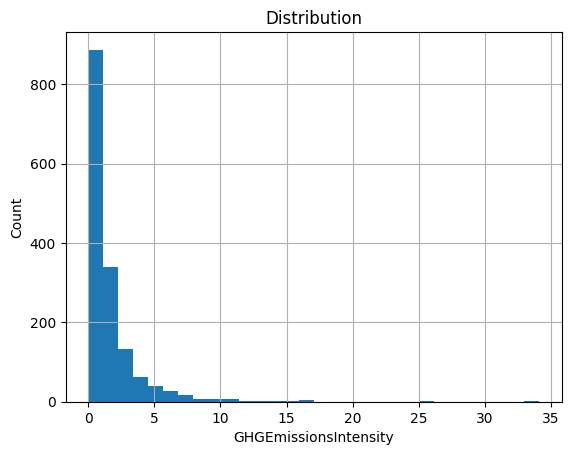

In [73]:
data_4['GHGEmissionsIntensity'].hist(bins=30)
plt.xlabel('GHGEmissionsIntensity')
plt.ylabel('Count')
plt.title('Distribution')
plt.show()

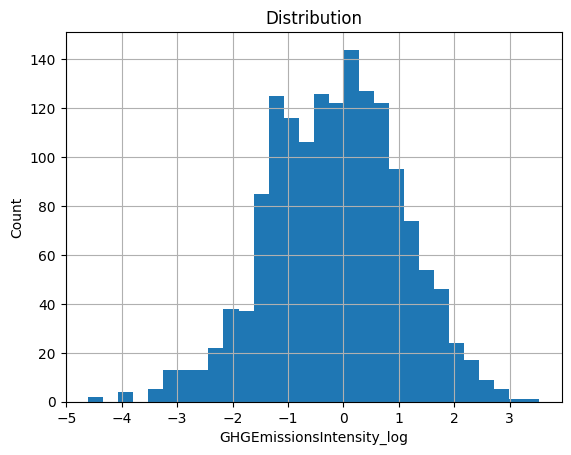

In [74]:
# Transform the target variable using the logarithmic function

data_num['GHGEmissionsIntensity_log'] = np.log(data['GHGEmissionsIntensity'])

data_num['GHGEmissionsIntensity_log'].hist(bins=30)
plt.xlabel('GHGEmissionsIntensity_log')
plt.ylabel('Count')
plt.title('Distribution')
plt.show()

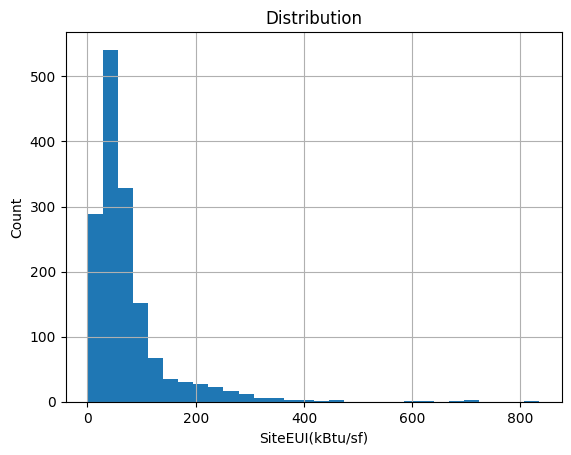

In [75]:
data_num['SiteEUI(kBtu/sf)'].hist(bins=30)
plt.xlabel('SiteEUI(kBtu/sf)')
plt.ylabel('Count')
plt.title('Distribution')
plt.show()

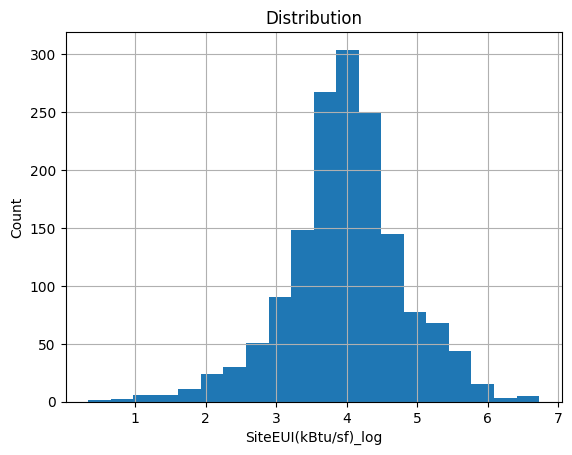

In [76]:
data_num['SiteEUI(kBtu/sf)_log'] = np.log(data['SiteEUI(kBtu/sf)'])

data_num['SiteEUI(kBtu/sf)_log'].hist(bins=20)
plt.xlabel('SiteEUI(kBtu/sf)_log')
plt.ylabel('Count')
plt.title('Distribution')
plt.show()

In [82]:
features = pd.concat([data_num, Energy_type, encoded_data_Neighbor, encoded_data_Built, data_PropertyUseTypes], axis=1)
features.to_csv('features.csv')